![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/2.Clinical_Assertion_Model.ipynb)

# Clinical Assertion Status Model 


The deep neural network architecture for assertion status detection in Spark NLP is based on a Bi-LSTM framework, and is a modified version of the architecture proposed by Federico Fancellu, Adam Lopez and Bonnie Webber ([Neural Networks For Negation Scope Detection](https://aclanthology.org/P16-1047.pdf)). Its goal is to classify the assertions made on given medical concepts as being present, absent, or possible in the patient, conditionally present in the patient under certain circumstances,
hypothetically present in the patient at some future point, and
mentioned in the patient report but associated with someoneelse.
In the proposed implementation, input units depend on the
target tokens (a named entity) and the neighboring words that
are explicitly encoded as a sequence using word embeddings.
Similar to paper mentioned above,  it is observed that that 95% of the scope tokens (neighboring words) fall in a window of 9 tokens to the left and 15
to the right of the target tokens in the same dataset. Therefore, the same window size was implemented and it following parameters were used: learning
rate 0.0012, dropout 0.05, batch size 64 and a maximum sentence length 250. The model has been implemented within
Spark NLP as an annotator called AssertionDLModel. After
training 20 epoch and measuring accuracy on the official test
set, this implementation exceeds the latest state-of-the-art
accuracy benchmarks as summarized as following table:

|Assertion Label|Spark NLP|Latest Best|
|-|-|-|
|Absent       |0.944 |0.937|
|Someone-else |0.904|0.869|
|Conditional  |0.441|0.422|
|Hypothetical |0.862|0.890|
|Possible     |0.680|0.630|
|Present      |0.953|0.957|
|micro F1     |0.939|0.934|


**Setup**

In [ ]:
import sys
import json
import os
with open('license.json') as f:
    license_keys = json.load(f)
    
import os
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [ ]:
import json
import os

from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

import sparknlp_jsl
import sparknlp

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G", 
          "spark.kryoserializer.buffer.max":"2000M", 
          "spark.driver.maxResultSize":"2000M"} 

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


In [ ]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

# Clinical Assertion Models (with pretrained models)

|    | model_name              |Predicted Entities|
|---:|:------------------------|-|
|  1 | assertion_dl            |Present, Absent, Possible, Planned, Someoneelse, Past, Family, None, Hypotetical|
|  2 | assertion_dl_biobert    |absent, present, conditional, associated_with_someone_else, hypothetical, possible|
|  3 | assertion_dl_healthcare |absent, present, conditional, associated_with_someone_else, hypothetical, possible|
|  4 | assertion_dl_large      |hypothetical, present, absent, possible, conditional, associated_with_someone_else|
|  5 | assertion_dl_radiology  |Confirmed, Suspected, Negative|
|  6 | assertion_jsl           |Present, Absent, Possible, Planned, Someoneelse, Past, Family, None, Hypotetical|
|  7 | assertion_jsl_large     |present, absent, possible, planned, someoneelse, past|
|  8 | assertion_ml            |Hypothetical, Present, Absent, Possible, Conditional, Associated_with_someone_else|

### Pretrained `assertion_dl` model

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

from sparknlp_jsl.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\
    #.setIncludeAllConfidenceScores(False)

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

# Assertion model trained on i2b2 (sampled from MIMIC) dataset
# coming from sparknlp_jsl.annotator !!
clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
    
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    clinical_assertion
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]


In [ ]:
AssertionDLApproach().extractParamMap()

{Param(parent='AssertionDLApproach_3709a7420449', name='batchSize', doc='Size for each batch in the optimization process'): 64,
 Param(parent='AssertionDLApproach_3709a7420449', name='dropout', doc='Dropout at the output of each layer'): 0.05,
 Param(parent='AssertionDLApproach_3709a7420449', name='epochs', doc='Number of epochs for the optimization process'): 5,
 Param(parent='AssertionDLApproach_3709a7420449', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): False,
 Param(parent='AssertionDLApproach_3709a7420449', name='label', doc='Column with one label per document'): 'label',
 Param(parent='AssertionDLApproach_3709a7420449', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='AssertionDLApproach_3709a7420449', name='learningRate', doc='Learning rate for the optimization process'): 0.0012,
 Param(parent='AssertionDLApproach_3709a7420449', name='maxSentLen', doc='Max length fo

In [ ]:
# we also have a LogReg based Assertion Model.
'''
clinical_assertion_ml = AssertionLogRegModel.pretrained("assertion_ml", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
'''

In [ ]:
import pandas as pd

text = 'Patient has a headache for the last 2 weeks, needs to get a head CT, and appears anxious when she walks fast. No alopecia noted. She denies pain'

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

Patient has a headache for the last 2 weeks, needs to get a head CT, and appears anxious when she walks fast. No alopecia noted. She denies pain


,chunks,entities,assertion
0,a headache,PROBLEM,present
1,a head CT,TEST,present
2,anxious,PROBLEM,present
3,alopecia,PROBLEM,absent
4,pain,PROBLEM,absent


In [ ]:
from sparknlp_display import AssertionVisualizer

vis = AssertionVisualizer()

vis.set_label_colors({'TEST':'#008080', 'PROBLEM':'#800080'})

vis.display(light_result, 'ner_chunk', 'assertion')

In [ ]:
! wget -q	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv

In [ ]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("pubmed_sample_text_small.csv")\
                
pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"""Monomeric sarcosine oxidase (MSOX) is a flav...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [ ]:
result = model.transform(pubMedDF.limit(100))

In [ ]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|           assertion|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[{document, 0, 95...|[{document, 0, 12...|[{token, 0, 2, Th...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 48, 106,...|[{assertion, 48, ...|
|BACKGROUND: At pr...|[{document, 0, 14...|[{document, 0, 19...|[{token, 0, 9, BA...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 67, 79, ...|[{assertion, 67, ...|
|OBJECTIVE: To inv...|[{document, 0, 15...|[{document, 0, 30...|[{token, 0, 8, OB...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 188, 231...|[{

In [ ]:
result.select('sentence.result').take(1)

[Row(result=['The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activated inwardly rectifying potassium (GIRK) channel family.', 'Here we describe the genomicorganization of the KCNJ9 locus on chromosome 1q21-23 as a candidate gene forType II diabetes mellitus in the Pima Indian population.', 'The gene spansapproximately 7.6 kb and contains one noncoding and two coding exons separated byapproximately 2.2 and approximately 2.6 kb introns, respectively.', 'We identified14 single nucleotide polymorphisms (SNPs), including one that predicts aVal366Ala substitution, and an 8 base-pair', '(bp) insertion/deletion.', 'Ourexpression studies revealed the presence of the transcript in various humantissues including pancreas, and two major insulin-responsive tissues: fat andskeletal muscle.', 'The characterization of the KCNJ9 gene should facilitate furtherstudies on the function of the KCNJ9 protein and allow evaluation of thepotential role of the locus in Type II diabetes.'])]

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result',  
                                     'ner_chunk.begin', 
                                     'ner_chunk.end', 
                                     'ner_chunk.metadata', 
                                     'assertion.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']").alias("begin"),
              F.expr("cols['2']").alias("end"),
              F.expr("cols['3']['entity']").alias("ner_label"),
              F.expr("cols['3']['sentence']").alias("sent_id"),
              F.expr("cols['4']").alias("assertion"),).show(truncate=False)


+-----------------------------------------------------------+-----+---+---------+-------+-----------+
|chunk                                                      |begin|end|ner_label|sent_id|assertion  |
+-----------------------------------------------------------+-----+---+---------+-------+-----------+
|the G-protein-activated inwardly rectifying potassium (GIRK|48   |106|TREATMENT|0      |conditional|
|the genomicorganization                                    |142  |164|TREATMENT|1      |present    |
|a candidate gene forType II diabetes mellitus              |210  |254|PROBLEM  |1      |present    |
|byapproximately                                            |380  |394|TREATMENT|2      |present    |
|single nucleotide polymorphisms                            |464  |494|TREATMENT|3      |present    |
|aVal366Ala substitution                                    |532  |554|PROBLEM  |3      |present    |
|an 8 base-pair                                             |561  |574|PROBLEM  |3

### Pretrained `assertion_dl_radiology` model

In [ ]:
from sparknlp_jsl.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentenceDetector = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

# NER model for radiology
radiology_ner = MedicalNerModel.pretrained("ner_radiology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\
    #.setIncludeAllConfidenceScores(False)

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["ImagingFindings"])

# Assertion model trained on radiology dataset
# coming from sparknlp_jsl.annotator !!

radiology_assertion = AssertionDLModel.pretrained("assertion_dl_radiology", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    radiology_ner,
    ner_converter,
    radiology_assertion
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
radiologyAssertion_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_radiology download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl_radiology download started this may take some time.
Approximate size to download 1.3 MB
[OK!]


In [ ]:
# A sample text from a radiology report

text = """No right-sided pleural effusion or pneumothorax is definitively seen and there are mildly displaced fractures of the left lateral 8th and likely 9th ribs."""

In [ ]:
data = spark.createDataFrame([[text]]).toDF("text")

In [ ]:
result = radiologyAssertion_model.transform(data)

In [ ]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 
                                     'ner_chunk.metadata', 
                                     'assertion.result')).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label"),
              F.expr("cols['1']['sentence']").alias("sent_id"),
              F.expr("cols['2']").alias("assertion")).show(truncate=False)

+-------------------+---------------+-------+---------+
|chunk              |ner_label      |sent_id|assertion|
+-------------------+---------------+-------+---------+
|effusion           |ImagingFindings|0      |Negative |
|pneumothorax       |ImagingFindings|0      |Negative |
|displaced fractures|ImagingFindings|0      |Confirmed|
+-------------------+---------------+-------+---------+



## Writing a generic Assertion + NER function

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id


def get_base_pipeline (embeddings = 'embeddings_clinical'):

    documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

  # Sentence Detector annotator, processes various sentences per line
    sentenceDetector = SentenceDetector()\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

  # Tokenizer splits words in a relevant format for NLP
    tokenizer = Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

  # Clinical word embeddings trained on PubMED dataset
    word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
        .setInputCols(["sentence", "token"])\
        .setOutputCol("embeddings")

    base_pipeline = Pipeline(stages=[
                        documentAssembler,
                        sentenceDetector,
                        tokenizer,
                        word_embeddings])

    return base_pipeline



def get_clinical_assertion (embeddings, spark_df, nrows = 100, model_name = 'ner_clinical'):

  # NER model trained on i2b2 (sampled from MIMIC) dataset
    loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")

    ner_converter = NerConverter() \
        .setInputCols(["sentence", "token", "ner"]) \
        .setOutputCol("ner_chunk")

  # Assertion model trained on i2b2 (sampled from MIMIC) dataset
  # coming from sparknlp_jsl.annotator !!
    clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
        .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
        .setOutputCol("assertion")
      

    base_model = get_base_pipeline (embeddings)

    nlpPipeline = Pipeline(stages=[
        base_model,
        loaded_ner_model,
        ner_converter,
        clinical_assertion])

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    model = nlpPipeline.fit(empty_data)

    result = model.transform(spark_df.limit(nrows))

    result = result.withColumn("id", monotonically_increasing_id())

    result_df = result.select(F.explode(F.arrays_zip('ner_chunk.result', 
                                                     'ner_chunk.metadata', 
                                                     'assertion.result')).alias("cols")) \
                      .select(F.expr("cols['0']").alias("chunk"),
                              F.expr("cols['1']['entity']").alias("ner_label"),
                              F.expr("cols['2']").alias("assertion"))\
                      .filter("ner_label!='O'")

    return result_df

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical_large'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show(30,truncate=50)

ner_clinical_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+--------------------------------------------------+---------+-----------+
|                                             chunk|ner_label|  assertion|
+--------------------------------------------------+---------+-----------+
|the G-protein-activated inwardly rectifying pot...|TREATMENT|conditional|
|                           the genomicorganization|TREATMENT|    present|
|     a candidate gene forType II diabetes mellitus|  PROBLEM|    present|
|                                   byapproximately|TREATMENT|    present|
|                   single nucleotide polymorphisms|TREATMENT|    present|
|                           aVal366Ala substitution|  PROBLEM|    present|
|                   

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------+---------+---------+
|           chunk|ner_label|assertion|
+----------------+---------+---------+
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|  present|
|     vinorelbine|     DRUG|  present|
|     vinorelbine|     DRUG|  present|
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|  present|
|  Vinorelbinewas|     DRUG|   absent|
|       25 mg/m(2| STRENGTH|  present|
|   intravenously|    ROUTE|   absent|
|         on days|FREQUENCY|  present|
| thatvinorelbine|     DRUG|  present|
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|  present|
|             DOX|     DRUG|   absent|
|    trandolapril|     DRUG| possible|

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology_greedy'

entry_data = spark.createDataFrame([["The patient did not take a capsule of Advil."]]).toDF("text")

ner_df = get_clinical_assertion (embeddings, entry_data, nrows, model_name)

ner_df.show()

ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------+---------+---------+
|           chunk|ner_label|assertion|
+----------------+---------+---------+
|capsule of Advil|     DRUG|   absent|
+----------------+---------+---------+



In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

entry_data = spark.createDataFrame([["The patient has no fever"]]).toDF("text")

ner_df = get_clinical_assertion (embeddings, entry_data, nrows, model_name)

ner_df.show()

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+-----+---------+---------+
|chunk|ner_label|assertion|
+-----+---------+---------+
|fever|  PROBLEM|   absent|
+-----+---------+---------+



In [ ]:
import pandas as pd

def get_clinical_assertion_light (light_model, text):

  light_result = light_model.fullAnnotate(text)[0]

  chunks=[]
  entities=[]
  status=[]

  for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
      
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 
      status.append(m.result)
          
  df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

  return df

In [ ]:
clinical_text = """
Patient with severe fever and sore throat. 
He shows no stomach pain and he maintained on an epidural and PCA for pain control.
He also became short of breath with climbing a flight of stairs.
After CT, lung tumor located at the right lower lobe. Father with Alzheimer.
"""

light_model = LightPipeline(model)

get_clinical_assertion_light (light_model, clinical_text)


,chunks,entities,assertion
0,severe fever,PROBLEM,present
1,sore throat,PROBLEM,present
2,stomach pain,PROBLEM,absent
3,an epidural,TREATMENT,present
4,PCA,TREATMENT,present
5,pain control,PROBLEM,present
6,short of breath,PROBLEM,conditional
7,CT,TEST,present
8,lung tumor,PROBLEM,present
9,Alzheimer,PROBLEM,associated_with_someone_else


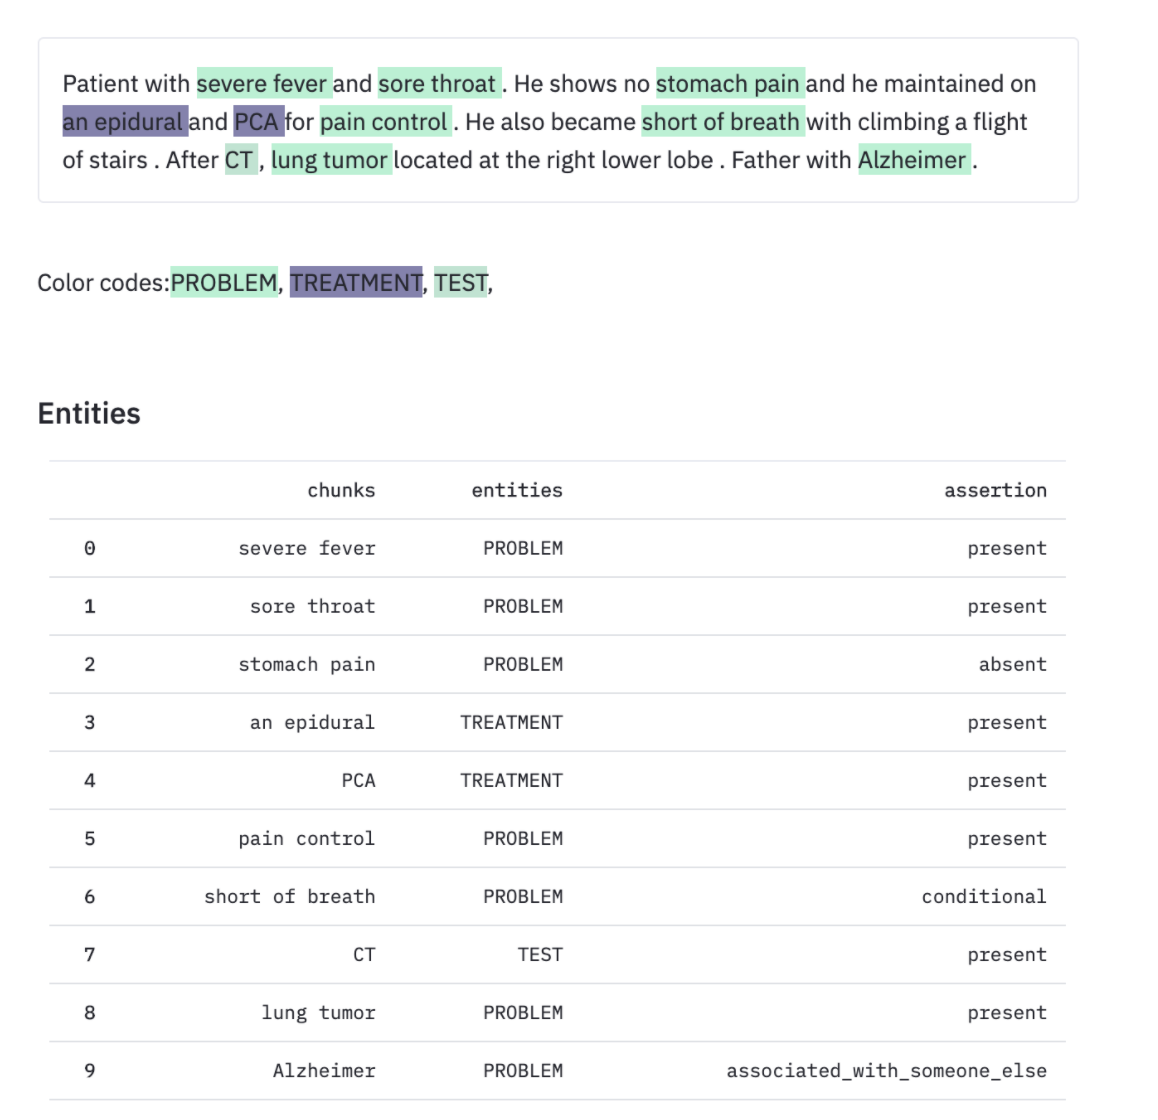

## Assertion with BioNLP (Cancer Genetics) NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show(truncate = False)

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------------+--------------------+-----------+
|chunk                 |ner_label           |assertion  |
+----------------------+--------------------+-----------+
|human                 |Organism            |present    |
|Kir 3.3               |Gene_or_gene_product|present    |
|GIRK3                 |Gene_or_gene_product|present    |
|potassium             |Simple_chemical     |conditional|
|GIRK                  |Gene_or_gene_product|conditional|
|chromosome 1q21-23    |Cellular_component  |present    |
|pancreas              |Organ               |present    |
|tissues               |Tissue              |possible   |
|fat andskeletal muscle|Tissue              |possible   |
|KCNJ9 

# Assertion Filterer
AssertionFilterer will allow you to filter out the named entities by the list of acceptable assertion statuses. This annotator would be quite handy if you want to set a white list for the acceptable assertion statuses like present or conditional; and do not want absent conditions get out of your pipeline.

In [ ]:
clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\
    #.setIncludeAllConfidenceScores(False)

ner_converter = NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = AssertionFilterer()\
    .setInputCols("sentence","ner_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setWhiteList(["present"])

nlpPipeline = Pipeline(stages=[
      documentAssembler, 
      sentenceDetector,
      tokenizer,
      word_embeddings,
      clinical_ner,
      ner_converter,
      clinical_assertion,
      assertion_filterer
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
assertionFilter_model = nlpPipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]


In [ ]:
text = 'Patient has a headache for the last 2 weeks, needs to get a head CT, and appears anxious when she walks fast. Alopecia noted. She denies pain.'

light_model = LightPipeline(assertionFilter_model)
light_result = light_model.annotate(text)

light_result.keys()

dict_keys(['assertion_filtered', 'document', 'ner_chunk', 'assertion', 'token', 'ner', 'embeddings', 'sentence'])

In [ ]:
list(zip(light_result['ner_chunk'], light_result['assertion']))

[('a headache', 'present'),
 ('a head CT', 'present'),
 ('anxious', 'present'),
 ('fast', 'present'),
 ('Alopecia', 'present'),
 ('pain', 'absent')]

In [ ]:
assertion_filterer.getWhiteList()

['present']

In [ ]:
light_result['assertion_filtered']

['a headache', 'a head CT', 'anxious', 'fast', 'Alopecia']

# Train a custom Assertion Model

In [ ]:
!wget -q https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion_sample.csv

In [ ]:
import pandas as pd

In [ ]:
assertion_df = spark.read.option("header", True).option("inferSchema", "True").csv("i2b2_assertion_sample.csv")

In [ ]:
assertion_df.show(3, truncate=100)

+-----------------------------------------------------------------------------+--------------------+-------+-----+---+
|                                                                         text|              target|  label|start|end|
+-----------------------------------------------------------------------------+--------------------+-------+-----+---+
|Due to dye load required to assess the coronary disease were not visualized .|the coronary disease|present|    7|  9|
|                            She has no history of liver disease , hepatitis .|       liver disease| absent|    5|  6|
|                                                     1. Undesired fertility .| undesired fertility|present|    1|  2|
+-----------------------------------------------------------------------------+--------------------+-------+-----+---+
only showing top 3 rows



In [ ]:
(training_data, test_data) = assertion_df.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 814
Test Dataset Count: 186


In [ ]:
training_data.groupBy('label').count().orderBy('count', ascending=False).show(truncate=False)

+----------------------------+-----+
|label                       |count|
+----------------------------+-----+
|present                     |546  |
|absent                      |182  |
|hypothetical                |41   |
|possible                    |34   |
|associated_with_someone_else|6    |
|conditional                 |5    |
+----------------------------+-----+



In [ ]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

chunk = Doc2Chunk()\
    .setInputCols("document")\
    .setOutputCol("chunk")\
    .setChunkCol("target")\
    .setStartCol("start")\
    .setStartColByTokenIndex(True)\
    .setFailOnMissing(False)\
    .setLowerCase(True)

token = Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


We will transform our test data with a pipeline consisting of same steps with the pipeline which contains AssertionDLApproach.
By doing this, we enable that test data will have same columns with training data in AssertionDLApproach. <br/>
The goal of this implementation is enabling the usage of `setTestDataset()` parameter in AssertionDLApproach. 

In [ ]:
clinical_assertion_pipeline = Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings])

assertion_test_data = clinical_assertion_pipeline.fit(test_data).transform(test_data)

In [ ]:
assertion_test_data.columns

['text',
 'target',
 'label',
 'start',
 'end',
 'document',
 'chunk',
 'token',
 'embeddings']

We save the test data in parquet format to use in `AssertionDLApproach()`. 

In [ ]:
assertion_test_data.write.parquet('i2b2_assertion_sample_test_data.parquet')

Graph setup

In [ ]:
!mkdir training_logs
!mkdir tf_graphs

# ready to use tf_graph
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/nerdl_graph/blstm_34_32_30_200_6.pb -P /content/tf_graphs

In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow-addons

In [ ]:
# Create custom graph

# from sparknlp_jsl.training import tf_graph
# tf_graph.print_model_params("assertion_dl")

# feat_size = 200
# n_classes = 6

# tf_graph.build("assertion_dl",
#               build_params={"n_classes": n_classes},
#               model_location= "./tf_graphs", 
#               model_filename="blstm_34_32_30_{}_{}.pb".format(feat_size, n_classes))

**Setting the Scope Window (Target Area) Dynamically in Assertion Status Detection Models**


This parameter allows you to train the Assertion Status Models to focus on specific context windows when resolving the status of a NER chunk. The window is in format `[X,Y]` being `X` the number of tokens to consider on the left of the chunk, and `Y` the max number of tokens to consider on the right. Let’s take a look at what different windows mean:


*   By default, the window is `[-1,-1]` which means that the Assertion Status will look at all of the tokens in the sentence/document (up to a maximum of tokens set in `setMaxSentLen()` ).
*   `[0,0]` means “don’t pay attention to any token except the ner_chunk”, what basically is not considering any context for the Assertion resolution.
*   `[9,15]` is what empirically seems to be the best baseline, meaning that we look up to 9 tokens on the left and 15 on the right of the ner chunk to understand the context and resolve the status.


Check this [Scope Window Tuning Assertion Status Detection notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/2.1.Scope_window_tuning_assertion_status_detection.ipynb)  that illustrates the effect of the different windows and how to properly fine-tune your AssertionDLModels to get the best of them.

In our case, the best Scope Window is around [10,10]

In [ ]:
scope_window = [10,10]

assertionStatus = AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(128)\
    .setDropout(0.1)\
    .setLearningRate(0.001)\
    .setEpochs(50)\
    .setValidationSplit(0.2)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setMaxSentLen(250)\
    .setEnableOutputLogs(True)\
    .setOutputLogsPath('training_logs/')\
    .setGraphFolder('tf_graphs')\
    .setTestDataset(path="/content/i2b2_assertion_sample_test_data.parquet", read_as='SPARK', options={'format': 'parquet'})\
    .setScopeWindow(scope_window)

'''
If .setTestDataset parameter is employed, raw test data cannot be fitted. .setTestDataset only works for dataframes which are correctly transformed
by a pipeline consisting of document, chunk, embeddings stages.
'''

In [ ]:
'''
assertionStatus = AssertionLogRegApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setMaxIter(100) # default: 26
'''

In [ ]:
clinical_assertion_pipeline = Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    assertionStatus])

In [ ]:
%%time

assertion_model = clinical_assertion_pipeline.fit(training_data)

CPU times: user 3.08 s, sys: 349 ms, total: 3.43 s
Wall time: 7min 36s


Checking the results saved in the log file

In [ ]:
import os

log_files = os.listdir("/content/training_logs")
log_files

['AssertionDLApproach_8ebb41f10e83.log']

In [ ]:
with open("/content/training_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: blstm_34_32_30_200_6.pb
Training started, trainExamples: 814


Epoch: 0 started, learning rate: 0.001, dataset size: 652
Done, 10.052912569 total training loss: 8.327478, avg training loss: 1.3879131, batches: 6
Quality on validation dataset (20.0%), validation examples = 162
time to finish evaluation: 1.30s
Total validation loss: 2.4327	Avg validation loss: 1.2163
label	 tp	 fp	 fn	 prec	 rec	 f1
absent	 0	 0	 39	 0.0	 0.0	 0.0
present	 104	 58	 0	 0.6419753	 1.0	 0.7819549
conditional	 0	 0	 2	 0.0	 0.0	 0.0
associated_with_someone_else	 0	 0	 1	 0.0	 0.0	 0.0
hypothetical	 0	 0	 10	 0.0	 0.0	 0.0
possible	 0	 0	 6	 0.0	 0.0	 0.0
tp: 104 fp: 58 fn: 58 labels: 6
Macro-average	 prec: 0.10699588, rec: 0.16666667, f1: 0.13032581
Micro-average	 prec: 0.6419753, rec: 0.6419753, f1: 0.6419753


Quality on test dataset: 
time to finish evaluation: 1.15s
Total test loss: 2.3395	Avg test loss: 1.1697
label	 tp	 fp	 fn	 prec	 rec	 f1
absent	 0	 0	 46	 0.0	 0.0	 0.0
p

In [ ]:
preds = assertion_model.transform(test_data).select('label','assertion.result')

preds.show()

+------------+---------+
|       label|   result|
+------------+---------+
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|hypothetical|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
+------------+---------+
only showing top 20 rows



In [ ]:
preds_df = preds.toPandas()

In [ ]:
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])
preds_df

,label,result
0,present,present
1,present,present
2,present,present
3,present,present
4,present,present
...,...,...
181,present,present
182,absent,absent
183,present,present
184,present,present


In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['label']))

                              precision    recall  f1-score   support

                      absent       0.54      0.78      0.64        32
associated_with_someone_else       0.00      0.00      0.00         0
                 conditional       0.00      0.00      0.00         0
                hypothetical       0.33      0.38      0.35         8
                    possible       0.00      0.00      0.00         0
                     present       0.92      0.75      0.83       146

                    accuracy                           0.74       186
                   macro avg       0.30      0.32      0.30       186
                weighted avg       0.83      0.74      0.77       186



In [ ]:
# save model
assertion_model.stages[-1].write().overwrite().save('assertion_model')